In [44]:
import numpy as np
import pandas as pd
import os
import tarfile
from six.moves import urllib
import zipfile
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics

In [4]:
def read_data(path):
    '''
    After we unzip the file, this function will read the txt file which is a line-delimited json file and produce
    a pandas dataframe.
    path: directory in which we saved the unzipped file.
    '''
    my_list =[]
    with open(path) as f:
        for line in f:
            json_content = json.loads(line)
            my_list.append(json_content)
    #df = pd.DataFrame(my_list) 
    return(pd.DataFrame(my_list))
    

**Step1: Data Exploration (EDA)**


In [6]:
df = read_data('data/transactions.txt')

In [7]:
df.shape # This data has 641914 records(observations) and 29 features.

(641914, 29)

In [8]:
df.replace(r'^\s*$', np.nan, regex=True, inplace=True) # Replacing blank values with nan. 

In [9]:
df.info() # this would give us a quick description of the data, in particular the total number of observations, and each attribute's type and number of non-null values.
# There are 641914 instances in the dataset. We have some numerical attributes like 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641914 entries, 0 to 641913
Data columns (total 29 columns):
accountNumber               641914 non-null object
accountOpenDate             641914 non-null object
acqCountry                  638001 non-null object
availableMoney              641914 non-null float64
cardCVV                     641914 non-null object
cardLast4Digits             641914 non-null object
cardPresent                 641914 non-null bool
creditLimit                 641914 non-null float64
currentBalance              641914 non-null float64
currentExpDate              641914 non-null object
customerId                  641914 non-null object
dateOfLastAddressChange     641914 non-null object
echoBuffer                  0 non-null float64
enteredCVV                  641914 non-null object
expirationDateKeyInMatch    641914 non-null bool
isFraud                     641914 non-null bool
merchantCategoryCode        641914 non-null object
merchantCity                0

There are 641914 instances in the dataset. We have some numerical attributes like 'availableMoney', 'creditLimit', and some categorical attributes like 'merchantCategoryCode', 'merchantName'. 
We have few attributes which totally have missing values. These attributes are:
- echoBuffer
- merchantCity
- merchantState
- merchantZip
- posOnPremises
- recurringAuthInd
We can drop these columns. 
Some attributes like 'acqCountry' has around 3913 missing values. We need to handle these missing values.

**handeling missing values**

We have few options:
- Totally drop those attributes from data.
- Drop those records (remove rows where these attributes are missing)
- Set the missing to some values. For numerical attributes, we can set them to the mean/median, and for categorical attributes we can set them to the most frequent category.

In [10]:
df.describe() # Basis statistical summary for numerical attributes.

,availableMoney,creditLimit,currentBalance,echoBuffer,merchantCity,merchantState,merchantZip,posOnPremises,recurringAuthInd,transactionAmount
count,641914.000000,641914.000000,641914.000000,0.0,0.0,0.0,0.0,0.0,0.0,641914.000000
mean,6652.828573,10697.210608,4044.382035,NaN,NaN,NaN,NaN,NaN,NaN,135.162497
std,9227.132275,11460.359133,5945.510224,NaN,NaN,NaN,NaN,NaN,NaN,147.053302
min,-1244.930000,250.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,1114.970000,5000.000000,502.442500,NaN,NaN,NaN,NaN,NaN,NaN,32.320000
50%,3578.165000,7500.000000,2151.860000,NaN,NaN,NaN,NaN,NaN,NaN,85.800000
75%,8169.185000,15000.000000,5005.890000,NaN,NaN,NaN,NaN,NaN,NaN,189.030000
max,50000.000000,50000.000000,47496.500000,NaN,NaN,NaN,NaN,NaN,NaN,1825.250000


Let's look at categorical features. For these features we can count unique value of them. 
We have some features like date, time which has objcet type, but it does not make sense to count their
unique values. So, I am not including them in my categorical feature list below.


In [11]:
cat_col =['acqCountry','cardPresent','expirationDateKeyInMatch','isFraud','merchantCategoryCode',
          'merchantCountryCode','merchantName','posConditionCode','posEntryMode','transactionType']
for c_ in cat_col:
    print('count of unique values of {} is as follows'.format(str(c_)))
    print(df[c_].value_counts())
    print('\n')

count of unique values of acqCountry is as follows
US     632303
MEX      2626
CAN      1870
PR       1202
Name: acqCountry, dtype: int64


count of unique values of cardPresent is as follows
False    340453
True     301461
Name: cardPresent, dtype: int64


count of unique values of expirationDateKeyInMatch is as follows
False    640945
True        969
Name: expirationDateKeyInMatch, dtype: int64


count of unique values of isFraud is as follows
False    630612
True      11302
Name: isFraud, dtype: int64


count of unique values of merchantCategoryCode is as follows
online_retail           161469
fastfood                101196
entertainment            69138
food                     68245
rideshare                50574
online_gifts             33045
hotels                   22879
fuel                     22566
subscriptions            18376
personal care            16917
mobileapps               14614
health                   14344
online_subscriptions     11247
auto                    

**Step 2: Plot**


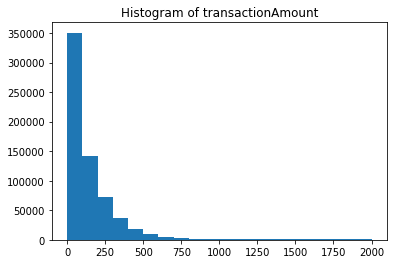

bins are:
[   0  100  200  300  400  500  600  700  800  900 1000 2000]
counts for each bin are:
[350445. 142390.  72474.  37202.  19001.   9918.   5127.   2539.   1398.
    682.    738.]


mean value of transactionAmount is 135.16249698556928
median value of transactionAmount is  85.8


In [270]:
# A histogram shows the number of instances (on the vertical axis) that have a 
# given value range (on the horizantal axis)
(n, bins,_) = plt.hist(df['transactionAmount'], bins=[0,100,200,300,400,500,600,700,800,900,1000,2000])
# binwidth = 200
# (n, bins,_) = plt.hist(df['transactionAmount'],
#                        bins=range(np.int(min(df['transactionAmount'])),
#                                   np.int(max(df['transactionAmount'])) + binwidth, binwidth))
plt.title('Histogram of transactionAmount')
plt.savefig("../results/transActionAmount_histogram.png")
plt.show()
print('bins are:')
print(bins)
print('counts for each bin are:')
print(n)
print('\n')
print('mean value of transactionAmount is {}'.format(np.mean(df['transactionAmount'])))
print('median value of transactionAmount is  {}'.format(np.median(df['transactionAmount'])))

From the histogram above (also count values for each bin), we observe that it has kind of right-skewed distribution (mean is in the right side of the median). Most of the transactions are concentrated around small values (in the range of [0,100]) and we have few observations for large value of transactions (amount >1000).
This is actually what we are expecting from a typical card data. Our day to day transactions would be small amounts, but large amounts would happen less frequent. These large amount could happen during special time (vacation travel during summer or holidays, one time big purchases, and so forth).


**Step 3: Data Wrangling - Duplicate Transactions**
- Identify reversed and multi-swipe transactions.


**One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal.**

In [271]:
# Let's first convert 'transactionDateTime' to an appropriate datetime fotmat that later, we can use it.
dateTime_pdf = df['transactionDateTime'].str.split('T',expand = True)

In [272]:
df['date'] = dateTime_pdf[0]
df['Time'] = dateTime_pdf[1]

In [273]:
df['dateTime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['Time'].astype(str))

In [274]:
df.sort_values(by=['customerId','accountNumber','dateTime'], inplace=True)

In [275]:
df[['customerId','accountNumber','dateTime','transactionAmount','transactionType']].head(10)

,customerId,accountNumber,dateTime,transactionAmount,transactionType
583485,100547107,100547107,2016-01-02 01:47:46,64.66,PURCHASE
583486,100547107,100547107,2016-01-16 23:35:41,5.31,PURCHASE
583487,100547107,100547107,2016-01-17 21:50:04,204.23,PURCHASE
583488,100547107,100547107,2016-01-29 05:19:50,155.28,PURCHASE
583489,100547107,100547107,2016-01-30 20:49:10,91.14,PURCHASE
583490,100547107,100547107,2016-02-06 22:31:44,2.80,PURCHASE
583491,100547107,100547107,2016-02-10 06:48:23,119.77,PURCHASE
583492,100547107,100547107,2016-02-11 08:28:07,211.11,PURCHASE
583493,100547107,100547107,2016-02-20 01:01:47,66.23,PURCHASE
583494,100547107,100547107,2016-02-26 04:02:55,1.06,PURCHASE


In [276]:
# reversal transactions
df_reversal = df[df.transactionType=='REVERSAL']
print('total number of reversed transaction is {} and total dollor amonut is ${:,}'\
     .format(df_reversal.shape[0],
             np.round(np.sum(df_reversal['transactionAmount']),2)))

total number of reversed transaction is 16162 and total dollor amonut is $2,242,915.1


Also for each reversed transaction, there should be one purchase transaction as well. So, estimate for the dollar amount should be around 2*2,242,915.1 (roughly $4million)

In [277]:
def find_purchase_for_reversal_transaction(tmp):
    reverse_dict ={}
    for i in range(tmp[tmp.transactionType=='REVERSAL'].shape[0]):
        reverse_dict[i] = (list(tmp[tmp.transactionType=='REVERSAL']['transactionType'])[i],
                          list(tmp[tmp.transactionType=='REVERSAL']['transactionAmount'])[i],
                          list(tmp[tmp.transactionType=='REVERSAL']['dateTime'])[i],
                          list(tmp[tmp.transactionType=='REVERSAL']['merchantName'])[i])
    reversal_merchant_list = {}
    for k,v in reverse_dict.items():
        reversal_merchant_list[v[3]] = v[2] 
        
    reversal_value_list = []
    for k,v in reverse_dict.items():
        reversal_value_list.append(v[1])  
        
    tmp['reversal_corr_purchace_flag'] = np.where((tmp.transactionType=='PURCHASE') & 
                                                  (tmp.transactionAmount.isin(reversal_value_list)) &
                                                  (tmp.merchantName.isin(reversal_merchant_list)),1,0)
    return(tmp)



    


In [278]:
df = df.groupby('customerId').apply(find_purchase_for_reversal_transaction)

Let's look at one specific customer. From table below 

In [279]:
df[df.customerId=='100634414'][['customerId','accountNumber',
                                'dateTime','transactionAmount',
                                'transactionType','merchantName','reversal_corr_purchace_flag']]

,customerId,accountNumber,dateTime,transactionAmount,transactionType,merchantName,reversal_corr_purchace_flag
104576,100634414,100634414,2016-01-14 20:12:08,56.09,PURCHASE,Rodeway Inn #211609,0
104577,100634414,100634414,2016-01-29 17:53:56,234.11,PURCHASE,target.com,0
104578,100634414,100634414,2016-02-22 10:43:17,0.00,ADDRESS_VERIFICATION,EZ Putt Putt #503815,0
104579,100634414,100634414,2016-03-08 20:34:23,23.27,PURCHASE,alibaba.com,0
104580,100634414,100634414,2016-03-11 14:39:30,130.57,PURCHASE,amazon.com,0
104581,100634414,100634414,2016-03-15 17:38:34,63.59,PURCHASE,Boston Cafe #592935,0
104582,100634414,100634414,2016-04-13 01:02:55,73.61,PURCHASE,Hilton Hotels #41865,0
104583,100634414,100634414,2016-06-13 20:49:02,85.51,PURCHASE,Dunkin' Donuts #48174,1
104584,100634414,100634414,2016-06-24 02:58:32,3.07,PURCHASE,Play Store,0
104585,100634414,100634414,2016-06-29 09:33:16,85.51,REVERSAL,Dunkin' Donuts #48174,0


**multi-swipe transactions**

This is how I identify them:
In a short time span(e.g 3 minutes), if I have transactions with same 'customerId','accountNumber',
'transactionAmount','transactionType', 'merchantName'

In [281]:
df['dup_flag'] = df.duplicated(['customerId','accountNumber','transactionAmount','transactionType','merchantName'],
                               keep=False)


In [282]:
df[df.dup_flag==True][['customerId','accountNumber',
                       'transactionAmount','transactionType','dateTime','dup_flag']].tail(20)

,customerId,accountNumber,transactionAmount,transactionType,dateTime,dup_flag
281756,999984515,999984515,63.28,PURCHASE,2016-04-18 20:40:31,True
281763,999984515,999984515,225.81,PURCHASE,2016-07-15 12:59:52,True
281764,999984515,999984515,225.81,PURCHASE,2016-07-15 12:59:53,True
281765,999984515,999984515,225.81,PURCHASE,2016-07-15 13:01:20,True
281768,999984515,999984515,63.28,PURCHASE,2016-08-07 17:30:28,True
281770,999984515,999984515,63.28,PURCHASE,2016-09-05 10:09:34,True
281771,999984515,999984515,63.28,PURCHASE,2016-09-18 19:30:28,True
281773,999984515,999984515,63.28,PURCHASE,2016-10-02 23:24:35,True
281776,999984515,999984515,63.28,PURCHASE,2016-11-14 06:22:54,True
281779,999984515,999984515,63.28,PURCHASE,2016-12-13 23:03:33,True


In [284]:
df['dateTime_lag'] = df.groupby(['customerId','accountNumber',
                                          'transactionAmount','transactionType'])['dateTime']\
                                .shift(1)
df['dateTime_diff'] =  df['dateTime'] - df['dateTime_lag'] 
df.sort_values(['customerId','accountNumber','transactionAmount','transactionType'],inplace=True)

In [285]:
df[df.dup_flag==True][['customerId','accountNumber','transactionAmount',
    'transactionType','dateTime','dateTime_lag','dateTime_diff','dup_flag']].head(20)

,customerId,accountNumber,transactionAmount,transactionType,dateTime,dateTime_lag,dateTime_diff,dup_flag
583510,100547107,100547107,0.00,PURCHASE,2016-05-29 19:23:34,NaT,NaT,True
583516,100547107,100547107,0.00,PURCHASE,2016-06-29 19:48:39,2016-05-29 19:23:34,31 days 00:25:05,True
583526,100547107,100547107,0.00,PURCHASE,2016-07-30 07:33:20,2016-06-29 19:48:39,30 days 11:44:41,True
583535,100547107,100547107,0.00,PURCHASE,2016-08-31 04:55:03,2016-07-30 07:33:20,31 days 21:21:43,True
583542,100547107,100547107,0.00,PURCHASE,2016-10-01 15:52:40,2016-08-31 04:55:03,31 days 10:57:37,True
583547,100547107,100547107,0.00,PURCHASE,2016-11-02 12:25:24,2016-10-01 15:52:40,31 days 20:32:44,True
583560,100547107,100547107,0.00,PURCHASE,2016-12-03 10:29:33,2016-11-02 12:25:24,30 days 22:04:09,True
104584,100634414,100634414,3.07,PURCHASE,2016-06-24 02:58:32,NaT,NaT,True
104587,100634414,100634414,3.07,PURCHASE,2016-07-25 07:13:21,2016-06-24 02:58:32,31 days 04:14:49,True
104590,100634414,100634414,3.07,PURCHASE,2016-08-24 14:10:53,2016-07-25 07:13:21,30 days 06:57:32,True


from table above, we see that altough there are some duplicated transactions, but they are happening with some monthly frequency. These charges are like monthly subscriptions fees. For example, you can see Apple iTunes charges a customer $3.70 almost every month.

So, now, to identify multi-swipe transactions, we aplly another filter on top of the table above using
'dateTime_diff' feature. For eaxmple we can filter dateTime_diff <= 3 minutes (multiple swipe happening in some merchant's cashier desk)

In [286]:
df['multi_swipe_flag'] = np.where(df.dateTime_diff <= pd.Timedelta(days=0,seconds = 180),1,0)



In [287]:
df[df.dup_flag==True][['customerId','accountNumber','transactionAmount',
    'transactionType','dateTime','dateTime_lag','dateTime_diff','merchantName','dup_flag','multi_swipe_flag']].head(20)

,customerId,accountNumber,transactionAmount,transactionType,dateTime,dateTime_lag,dateTime_diff,merchantName,dup_flag,multi_swipe_flag
583510,100547107,100547107,0.00,PURCHASE,2016-05-29 19:23:34,NaT,NaT,Apple iTunes,True,0
583516,100547107,100547107,0.00,PURCHASE,2016-06-29 19:48:39,2016-05-29 19:23:34,31 days 00:25:05,Apple iTunes,True,0
583526,100547107,100547107,0.00,PURCHASE,2016-07-30 07:33:20,2016-06-29 19:48:39,30 days 11:44:41,Apple iTunes,True,0
583535,100547107,100547107,0.00,PURCHASE,2016-08-31 04:55:03,2016-07-30 07:33:20,31 days 21:21:43,Apple iTunes,True,0
583542,100547107,100547107,0.00,PURCHASE,2016-10-01 15:52:40,2016-08-31 04:55:03,31 days 10:57:37,Apple iTunes,True,0
583547,100547107,100547107,0.00,PURCHASE,2016-11-02 12:25:24,2016-10-01 15:52:40,31 days 20:32:44,Apple iTunes,True,0
583560,100547107,100547107,0.00,PURCHASE,2016-12-03 10:29:33,2016-11-02 12:25:24,30 days 22:04:09,Apple iTunes,True,0
104584,100634414,100634414,3.07,PURCHASE,2016-06-24 02:58:32,NaT,NaT,Play Store,True,0
104587,100634414,100634414,3.07,PURCHASE,2016-07-25 07:13:21,2016-06-24 02:58:32,31 days 04:14:49,Play Store,True,0
104590,100634414,100634414,3.07,PURCHASE,2016-08-24 14:10:53,2016-07-25 07:13:21,30 days 06:57:32,Play Store,True,0


In [288]:
df[df.dup_flag==True][['customerId','accountNumber','transactionAmount','transactionType',
                       'dateTime','dateTime_lag','dateTime_diff','merchantName','dup_flag',
                       'multi_swipe_flag']].tail(20)

,customerId,accountNumber,transactionAmount,transactionType,dateTime,dateTime_lag,dateTime_diff,merchantName,dup_flag,multi_swipe_flag
281756,999984515,999984515,63.28,PURCHASE,2016-04-18 20:40:31,2016-02-23 05:06:01,55 days 15:34:30,Sunoco Gas #316345,True,0
281768,999984515,999984515,63.28,PURCHASE,2016-08-07 17:30:28,2016-04-18 20:40:31,110 days 20:49:57,Sunoco Gas #316345,True,0
281770,999984515,999984515,63.28,PURCHASE,2016-09-05 10:09:34,2016-08-07 17:30:28,28 days 16:39:06,Sunoco Gas #316345,True,0
281771,999984515,999984515,63.28,PURCHASE,2016-09-18 19:30:28,2016-09-05 10:09:34,13 days 09:20:54,Sunoco Gas #316345,True,0
281773,999984515,999984515,63.28,PURCHASE,2016-10-02 23:24:35,2016-09-18 19:30:28,14 days 03:54:07,Sunoco Gas #316345,True,0
281776,999984515,999984515,63.28,PURCHASE,2016-11-14 06:22:54,2016-10-02 23:24:35,42 days 06:58:19,Sunoco Gas #316345,True,0
281779,999984515,999984515,63.28,PURCHASE,2016-12-13 23:03:33,2016-11-14 06:22:54,29 days 16:40:39,Sunoco Gas #316345,True,0
281780,999984515,999984515,63.28,PURCHASE,2016-12-28 13:38:20,2016-12-13 23:03:33,14 days 14:34:47,Sunoco Gas #316345,True,0
281763,999984515,999984515,225.81,PURCHASE,2016-07-15 12:59:52,NaT,NaT,alibaba.com,True,0
281764,999984515,999984515,225.81,PURCHASE,2016-07-15 12:59:53,2016-07-15 12:59:52,0 days 00:00:01,alibaba.com,True,1


In [289]:
# to check our analysis, let's look at one case.
# You can see that multi-swipe is happening is 3 minutes time window.
df[(df.dup_flag==True) & (df.customerId=='105420594') & (df.transactionAmount==9.38)]\
       [['customerId','accountNumber','transactionAmount','transactionType',
        'dateTime','dateTime_lag','dateTime_diff','merchantName','dup_flag','multi_swipe_flag']].head(20)
         
         

,customerId,accountNumber,transactionAmount,transactionType,dateTime,dateTime_lag,dateTime_diff,merchantName,dup_flag,multi_swipe_flag
440718,105420594,105420594,9.38,PURCHASE,2016-04-13 06:33:13,NaT,NaT,apple.com,True,0
440719,105420594,105420594,9.38,PURCHASE,2016-04-13 06:35:12,2016-04-13 06:33:13,00:01:59,apple.com,True,1


In [290]:
print('total number of multi_swipe transaction is {} and total dollar amount is ${:,}'\
     .format(df[df.multi_swipe_flag==True].shape[0],
             np.round(np.sum(df[df.multi_swipe_flag==True]['transactionAmount']),2)))






total number of multi_swipe transaction is 6178 and total dollar amount is $886,953.58


In [291]:
# Put togther everyting into a function for multi-swipe transactions.
def multi_swipe(data, time_span = 180):
    '''
    time_span in seconds
    '''
    data['dup_flag'] = data.duplicated(['customerId','accountNumber','transactionAmount','transactionType','merchantName'],
                                     keep=False)
    data['dateTime_lag'] = data.groupby(['customerId','accountNumber',
                                          'transactionAmount','transactionType'])['dateTime']\
                                .shift(1)
    data['dateTime_diff'] =  data['dateTime'] - data['dateTime_lag'] 
    data.sort_values(['customerId','accountNumber','transactionAmount','transactionType'],inplace=True)
    data['multi_swipe_flag'] = np.where(df.dateTime_diff <= pd.Timedelta(days=0,seconds = time_span),1,0)
    return(data)

    
    
    
    
    
    

In [292]:
df = multi_swipe(data = df, time_span = 180)

In [293]:
df[(df.dup_flag==True) & (df.customerId=='105420594') & (df.transactionAmount==9.38)]\
       [['customerId','accountNumber','transactionAmount','transactionType',
        'dateTime','dateTime_lag','dateTime_diff','merchantName','dup_flag','multi_swipe_flag']].head(20)

,customerId,accountNumber,transactionAmount,transactionType,dateTime,dateTime_lag,dateTime_diff,merchantName,dup_flag,multi_swipe_flag
440718,105420594,105420594,9.38,PURCHASE,2016-04-13 06:33:13,NaT,NaT,apple.com,True,0
440719,105420594,105420594,9.38,PURCHASE,2016-04-13 06:35:12,2016-04-13 06:33:13,00:01:59,apple.com,True,1


**Step 4: Model**

In [2]:
df1=pd.read_csv('data/processed_balanced_transaction.csv')

In [3]:
df1.head()

,accountNumber,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,customerId,enteredCVV,...,transactionDateTime_day,transactionDateTime_hour,transactionDateTime_minute,transactionDateTime_second,currentExpDate_year,currentExpDate_month,currentExpDate_day,dateOfLastAddressChange_year,dateOfLastAddressChange_month,dateOfLastAddressChange_day
0,173544488,3,3060.76,711,460,1,7500.0,4439.24,173544488,711,...,30,22,45,7,2019,9,1,2014,4,12
1,109517864,3,250.00,912,4842,1,250.0,0.00,109517864,912,...,28,2,14,48,2024,3,1,2014,11,7
2,937106980,3,8272.83,312,92,1,15000.0,6727.17,937106980,312,...,9,12,0,17,2022,4,1,2016,9,16
3,942524230,3,5289.40,379,1683,1,7500.0,2210.60,942524230,379,...,8,4,17,52,2028,11,1,2008,11,16
4,899404344,3,3942.77,279,8069,1,5000.0,1057.23,899404344,279,...,9,11,35,49,2019,5,1,2012,3,22


In [4]:
df1.shape

(872136, 34)

In [6]:
df1.isnull().sum()

accountNumber                    0
acqCountry                       0
availableMoney                   0
cardCVV                          0
cardLast4Digits                  0
cardPresent                      0
creditLimit                      0
currentBalance                   0
customerId                       0
enteredCVV                       0
expirationDateKeyInMatch         0
isFraud                          0
merchantCategoryCode             0
merchantCountryCode              0
merchantName                     0
posConditionCode                 0
posEntryMode                     0
transactionAmount                0
transactionType                  0
accountOpenDate_year             0
accountOpenDate_month            0
accountOpenDate_day              0
transactionDateTime_year         0
transactionDateTime_month        0
transactionDateTime_day          0
transactionDateTime_hour         0
transactionDateTime_minute       0
transactionDateTime_second       0
currentExpDate_year 

In [12]:
# keep only features (columns) that could be helpful in idetifying fraud
response_feature = ['isFraud']
feature_to_keep = ['acqCountry','availableMoney','cardPresent','creditLimit','currentBalance',
                  'expirationDateKeyInMatch','merchantCategoryCode',
                  'merchantCountryCode','transactionAmount','cardPresent','transactionType']
                  
df1 = df1[response_feature + feature_to_keep]

In [14]:
df1.groupby('isFraud').count() # This shows that we have a balanced data now.

,acqCountry,availableMoney,cardPresent,creditLimit,currentBalance,expirationDateKeyInMatch,merchantCategoryCode,merchantCountryCode,transactionAmount,cardPresent,transactionType
isFraud,,,,,,,,,,,
0,436068,436068,436068,436068,436068,436068,436068,436068,436068,436068,436068
1,436068,436068,436068,436068,436068,436068,436068,436068,436068,436068,436068


In [20]:
X, y = df1.drop(columns=['isFraud'],axis=1), df1['isFraud']

In [21]:
# before we start anything, we split data into train and test, and put aside test part
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [22]:
lr_clf = LogisticRegression() # Logistic Regression

In [23]:
lr_clf.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
y_pred_lr = lr_clf.predict(X_test)

In [25]:
print('AUC for Logistic Regression Classifier is {}'.format(roc_auc_score(y_test, y_pred_lr)))



AUC for Logistic Regression Classifier is 0.63547840080688


In [27]:
print('Precision for Logistic Regression Classifier is {}'.format(precision_score(y_test, y_pred_lr)))



Precision for Logistic Regression Classifier is 0.6670020782982405


In [28]:
print('Recall for Logistic Regression Classifier is {}'.format(recall_score(y_test, y_pred_lr)))



Recall for Logistic Regression Classifier is 0.541812126165904


In [26]:
print('F1 score for Logistic Regression Classifier is {}'.format(f1_score(y_test, y_pred_lr)))



F1 score for Logistic Regression Classifier is 0.5979244996712246


## Let's do hyper parameter tuning

In [35]:

param_grids = {'penalty' : ['l1', 'l2'],
              'C' : [0.01,0.1,1,10],
              'solver' : ['liblinear'],
              'fit_intercept':[True,False]}
        


In [36]:
lr_clf_tune = GridSearchCV(LogisticRegression(), param_grids, cv = 10, n_jobs=-1)

In [37]:
model_lr_tune=lr_clf_tune.fit(X_train, y_train)

In [39]:
print(model_lr_tune.best_params_)

{'C': 1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}


In [40]:
y_pred_lr_cv=model_lr_tune.predict(X_test)

In [42]:
print('AUC for Logistic Regression Classifier is {}'.format(roc_auc_score(y_test, y_pred_lr_cv)))
print('Precision for Logistic Regression Classifier is {}'.format(precision_score(y_test, y_pred_lr_cv)))
print('Recall for Logistic Regression Classifier is {}'.format(recall_score(y_test, y_pred_lr_cv)))
print('F1 score for Logistic Regression Classifier is {}'.format(f1_score(y_test, y_pred_lr_cv)))







AUC for Logistic Regression Classifier is 0.6353672308013988
Precision for Logistic Regression Classifier is 0.6666604050043206
Recall for Logistic Regression Classifier is 0.5422017157218484
F1 score for Logistic Regression Classifier is 0.5980242232754082


In [45]:
target_names = ['Not Fraud', 'Fraud']
print(metrics.classification_report(y_test, y_pred_lr_cv, digits=3, target_names=target_names))


              precision    recall  f1-score   support

   Not Fraud      0.614     0.729     0.666    130734
       Fraud      0.667     0.542     0.598    130907

   micro avg      0.635     0.635     0.635    261641
   macro avg      0.640     0.635     0.632    261641
weighted avg      0.640     0.635     0.632    261641



In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [57]:
y_test00=y_test.replace({0:'Not Fraud',1:'Fraud'})


In [58]:
y_pred_lr_cv00=pd.DataFrame(y_pred_lr_cv).replace({0:'Not Fraud',1:'Fraud'})

Confusion matrix, without normalization
[[95244 35490]
 [59929 70978]]


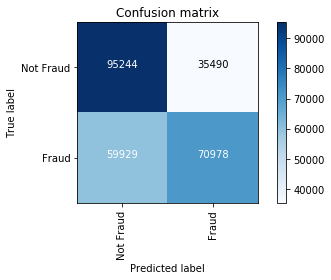

In [60]:
cnf_matrix = metrics.confusion_matrix(y_test00, y_pred_lr_cv00,labels=target_names)
np.set_printoptions(precision=2)


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')